# 4.3 Exploring and Pre-processing - Phase II
Reading Pulitzer Final data, i.e., after wrangling and first clean up. At this stage, I plan to do an in-depth analysis to find relationship and outliers and get the data preprocessed for ML.

# 4.3 Exploring and Pre-processing - Phase II
Reading Pulitzer Final data, i.e., after wrangling and first clean up. At this stage, I plan to do an in-depth analysis to find relationship and outliers and get the data preprocessed for ML.

In [1]:
#including basic header files 
import itertools
from multiprocessing import Pool
import sys
import time
from cassandra.cluster import Cluster
from cassandra.concurrent import execute_concurrent_with_args
from cassandra.query import tuple_factory
from cassandra.auth import PlainTextAuthProvider

import pandas as pd
from google.cloud import storage
import datetime as dt
from datetime import datetime
from pytz import timezone
import uuid

In [2]:
df_con=pd.read_csv('~/connection_point.csv',header=0) #connection headers
df_code=pd.read_csv('~/states_code.txt',header=0,sep='\t') #US State Dict
states_dict=dict(zip(df_code.Abbreviation,df_code.State)) #Creating the dict

### 4.3.1 Reading the Pulitzer Final Data from Cassandra

In [3]:
from IPython.display import display
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

def _fetchData(query_):
    cluster = Cluster(contact_points=[df_con.ip[0]], auth_provider = \
                      PlainTextAuthProvider(username=df_con.user[0], \
                                            password=df_con.token[0]))
    session = cluster.connect()
    session.set_keyspace('capstone')
    session.row_factory = pandas_factory    
    rows = session.execute(query_)
    return rows

if __name__ == "__main__":
    query_pram="SELECT  Newspaper,state,DailyCirculation_2004, \
                DailyCirculation_2013,ChangeDailyCirculation_2004_2013,\
                WinNFinalists_1990_2003,WinNFinalists_2004_2014,WinNFinalists_1990_2014, \
                GDP_2004,GDP_2013,GDP_2014,crimeindex,violentcrime_2004,\
                violentcrime_2013,violentcrime_2014,popestimate2004, \
                popestimate2013,popestimate2014 FROM capstone.pulitzerFinal"                                
    rows = _fetchData(query_pram)
    df_pulitzer=rows._current_rows 

### 4.3.2 Data Transformation

Removing commas,changing datatypes and US state two digit code. Please note that we will be moving this step to Section 3.0

In [4]:
df_pulitzer.sample(7)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
43,Denver Post,Colorado,"340,168","416,676",22%,1,8,9,204,286,305,1526,1360088,1168298,1165383,5349648.0,4720423.0,4803868.0
18,Philadelphia Inquirer,Pennsylvania,"376,454","306,831",-18%,24,8,32,483,659,684,1335,1360088,1168298,1165383,12790565.0,12510809.0,12563937.0
46,Boston Globe,Massachusetts,"446,241","245,572",-45%,25,16,41,330,442,459,1368,1360088,1168298,1165383,6749911.0,6410084.0,6431559.0
4,Detroit Free Press,Michigan,"379,304","209,652",-45%,7,5,12,382,429,445,1757,1360088,1168298,1165383,9915767.0,10036081.0,10001284.0
48,San Diego Union-Tribune,California,"355,771","250,678",-30%,0,2,2,1645,2223,2349,1701,1360088,1168298,1165383,38680808.0,36021200.0,36250312.0
17,San Francisco Chronicle,California,"499,008","218,987",-56%,7,2,9,1645,2223,2349,1701,1360088,1168298,1165383,38680808.0,36021200.0,36250312.0
1,Dallas Morning News,Texas,"528,379","409,265",-23%,11,6,17,909,1536,1614,1962,1360088,1168298,1165383,26944752.0,23359580.0,23831984.0


In [5]:
df_pulitzer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
newspaper                           50 non-null object
state                               50 non-null object
dailycirculation_2004               50 non-null object
dailycirculation_2013               50 non-null object
changedailycirculation_2004_2013    50 non-null object
winnfinalists_1990_2003             50 non-null object
winnfinalists_2004_2014             50 non-null object
winnfinalists_1990_2014             50 non-null object
gdp_2004                            50 non-null object
gdp_2013                            50 non-null object
gdp_2014                            50 non-null object
crimeindex                          50 non-null object
violentcrime_2004                   50 non-null object
violentcrime_2013                   50 non-null object
violentcrime_2014                   50 non-null object
popestimate2004                     50 non-null object
popestimate2013  

In [6]:
inv_map = {v: k for k, v in states_dict.items()}
df_pulitzer.state=df_pulitzer.state.apply(lambda x:inv_map[x])

df_pulitzer['dailycirculation_2013']=df_pulitzer.dailycirculation_2013.apply(lambda x: x.replace(',',''))
df_pulitzer['dailycirculation_2004']=df_pulitzer.dailycirculation_2004.apply(lambda x: x.replace(',',''))

df_pulitzer['dailycirculation_2013']=df_pulitzer.dailycirculation_2013.apply(lambda x: float(x))
df_pulitzer['dailycirculation_2004']=df_pulitzer.dailycirculation_2004.apply(lambda x: float(x))

df_pulitzer['winnfinalists_1990_2003']=df_pulitzer.winnfinalists_1990_2003.apply(lambda x: float(x))
df_pulitzer['winnfinalists_2004_2014']=df_pulitzer.winnfinalists_2004_2014.apply(lambda x: float(x))
df_pulitzer['winnfinalists_1990_2014']=df_pulitzer.winnfinalists_1990_2014.apply(lambda x: float(x))

df_pulitzer['gdp_2004']=df_pulitzer.gdp_2004.apply(lambda x: float(x))
df_pulitzer['gdp_2013']=df_pulitzer.gdp_2013.apply(lambda x: float(x))
df_pulitzer['gdp_2014']=df_pulitzer.gdp_2014.apply(lambda x: float(x))

df_pulitzer['crimeindex']=df_pulitzer.crimeindex.apply(lambda x: float(x))

df_pulitzer['violentcrime_2004']=df_pulitzer.violentcrime_2004.apply(lambda x: float(x))
df_pulitzer['violentcrime_2013']=df_pulitzer.violentcrime_2013.apply(lambda x: float(x))
df_pulitzer['violentcrime_2014']=df_pulitzer.violentcrime_2014.apply(lambda x: float(x))

df_pulitzer['popestimate2004']=df_pulitzer.popestimate2004.apply(lambda x: float(x))
df_pulitzer['popestimate2013']=df_pulitzer.popestimate2013.apply(lambda x: float(x))
df_pulitzer['popestimate2014']=df_pulitzer.popestimate2014.apply(lambda x: float(x))

In [7]:
df_pulitzer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
newspaper                           50 non-null object
state                               50 non-null object
dailycirculation_2004               50 non-null float64
dailycirculation_2013               50 non-null float64
changedailycirculation_2004_2013    50 non-null object
winnfinalists_1990_2003             50 non-null float64
winnfinalists_2004_2014             50 non-null float64
winnfinalists_1990_2014             50 non-null float64
gdp_2004                            50 non-null float64
gdp_2013                            50 non-null float64
gdp_2014                            50 non-null float64
crimeindex                          50 non-null float64
violentcrime_2004                   50 non-null float64
violentcrime_2013                   50 non-null float64
violentcrime_2014                   50 non-null float64
popestimate2004                     50 non-null float64
pope

In [8]:
df_pulitzer.sample(7)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
18,Philadelphia Inquirer,PA,376454.0,306831.0,-18%,24.0,8.0,32.0,483.0,659.0,684.0,1335.0,1360088.0,1168298.0,1165383.0,12790565.0,12510809.0,12563937.0
9,Sacramento Bee,CA,303841.0,200802.0,-34%,4.0,4.0,8.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
39,Boston Herald,MA,236899.0,95929.0,-60%,0.0,0.0,0.0,330.0,442.0,459.0,1368.0,1360088.0,1168298.0,1165383.0,6749911.0,6410084.0,6431559.0
48,San Diego Union-Tribune,CA,355771.0,250678.0,-30%,0.0,2.0,2.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
17,San Francisco Chronicle,CA,499008.0,218987.0,-56%,7.0,2.0,9.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
43,Denver Post,CO,340168.0,416676.0,22%,1.0,8.0,9.0,204.0,286.0,305.0,1526.0,1360088.0,1168298.0,1165383.0,5349648.0,4720423.0,4803868.0
20,San Jose Mercury News,CA,558874.0,583998.0,4%,4.0,2.0,6.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0


In [9]:
df_pulitzer=df_pulitzer.drop(['changedailycirculation_2004_2013'], axis=1) #droping calculated column

In [10]:
df_pulitzer

,newspaper,state,dailycirculation_2004,dailycirculation_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
0,Orlando Sentinel,FL,269269.0,161070.0,5.0,2.0,7.0,639.0,794.0,832.0,2095.0,1360088.0,1168298.0,1165383.0,19888740.0,18166990.0,18367842.0
1,Dallas Morning News,TX,528379.0,409265.0,11.0,6.0,17.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
2,Houston Chronicle,TX,549300.0,360251.0,2.0,3.0,5.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
3,Indianapolis Star,IN,253778.0,156850.0,1.0,0.0,1.0,238.0,311.0,324.0,1599.0,1360088.0,1168298.0,1165383.0,6595233.0,6332669.0,6379599.0
4,Detroit Free Press,MI,379304.0,209652.0,7.0,5.0,12.0,382.0,429.0,445.0,1757.0,1360088.0,1168298.0,1165383.0,9915767.0,10036081.0,10001284.0
5,Fort Woth Star-Telegram,TX,237318.0,188593.0,1.0,0.0,1.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
6,Chicago Tribune,IL,603315.0,414930.0,23.0,15.0,38.0,558.0,721.0,747.0,1616.0,1360088.0,1168298.0,1165383.0,12867544.0,12643955.0,12695866.0
7,Oregonian,OR,339169.0,228909.0,9.0,8.0,17.0,142.0,196.0,203.0,1497.0,1360088.0,1168298.0,1165383.0,3968371.0,3670883.0,3722417.0
8,New York Post,NY,642844.0,500521.0,0.0,0.0,0.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
9,Sacramento Bee,CA,303841.0,200802.0,4.0,4.0,8.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0


### 4.3.3 Analysis

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Let us find our the basic stats of Pulitzer data

In [12]:
df_pulitzer.sample(10)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
32,Daily Oklahoman,OK,223403.0,124667.0,0.0,0.0,0.0,113.0,186.0,196.0,1938.0,1360088.0,1168298.0,1165383.0,3877499.0,3594090.0,3634349.0
48,San Diego Union-Tribune,CA,355771.0,250678.0,0.0,2.0,2.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
30,Chicago Sun-Times,IL,453757.0,470548.0,1.0,1.0,2.0,558.0,721.0,747.0,1616.0,1360088.0,1168298.0,1165383.0,12867544.0,12643955.0,12695866.0
17,San Francisco Chronicle,CA,499008.0,218987.0,7.0,2.0,9.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
26,USA Today,VA,2192098.0,1674306.0,1.0,1.0,2.0,331.0,449.0,459.0,1125.0,1360088.0,1168298.0,1165383.0,8317372.0,7673725.0,7751000.0
12,Arizona Republic,AZ,466926.0,293640.0,5.0,2.0,7.0,204.0,270.0,280.0,2025.0,1360088.0,1168298.0,1165383.0,6719993.0,6029141.0,6167681.0
44,Newsday,NY,553117.0,377744.0,12.0,6.0,18.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
16,Cleveland Plain Dealer,OH,367528.0,311605.0,4.0,7.0,11.0,451.0,564.0,591.0,1691.0,1360088.0,1168298.0,1165383.0,11594408.0,11481213.0,11500468.0
0,Orlando Sentinel,FL,269269.0,161070.0,5.0,2.0,7.0,639.0,794.0,832.0,2095.0,1360088.0,1168298.0,1165383.0,19888740.0,18166990.0,18367842.0
14,Orange County Register,CA,310001.0,356165.0,3.0,2.0,5.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0


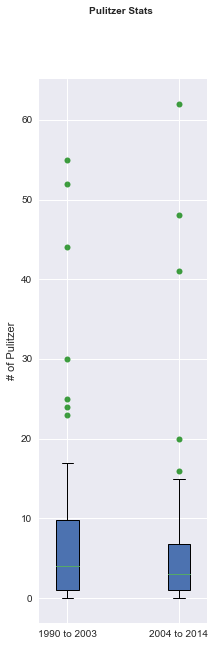

In [13]:
fig, axes = plt.subplots(figsize=(3, 10))
fig.suptitle('Pulitzer Stats', fontsize=10, fontweight='bold')
axes.set_ylabel('# of Pulitzer')

_ = axes.boxplot(
    [df_pulitzer.winnfinalists_1990_2003,df_pulitzer.winnfinalists_2004_2014], \
    positions = [1, 3], \
    labels = ['1990 to 2003','2004 to 2014'], \
    patch_artist = True, widths = 0.4,showfliers=True,sym='gx')

for flier in _['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=.75)
    
#fig, axes = plt.subplots(2,1, figsize=(3, 10))        
#bp=plt.boxplot(df_pulitzer.winnfinalists_1990_2003,widths=0.3,showfliers=True,  \
#               patch_artist=True,sym='b+',labels=['Pulitzer Price (1990 to 2003)'])

#for flier in bp['fliers']:
#    flier.set(marker='o', color='#e7298a', alpha=.75)
    
#print([item.get_ydata()[0] for item in _['whiskers']])
#print([item.get_ydata()[0] for item in _['medians']])
#print([item.get_ydata()[0] for item in _['caps']])
#axes.text(1.05, 7.25, '%.3f' % 6.75,  verticalalignment='center', fontsize=9)#, backgroundcolor="white")
plt.show()

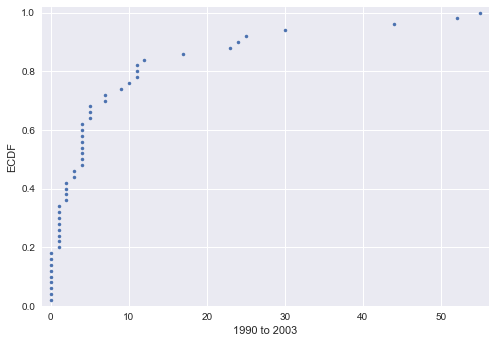

In [14]:
#Empirical Cumulative Distribution Function (ECDF)
import numpy as np
x=sorted(df_pulitzer.winnfinalists_1990_2003)
y=np.arange(1,len(x)+1)/len(x)
_=plt.plot(x,y,marker='.',linestyle='none')
_=plt.xlabel('1990 to 2003')
_=plt.ylabel('ECDF')
plt.margins(0.02)
plt.show()

#80% of the newpaper population is under 10 - 20% of population is above 10

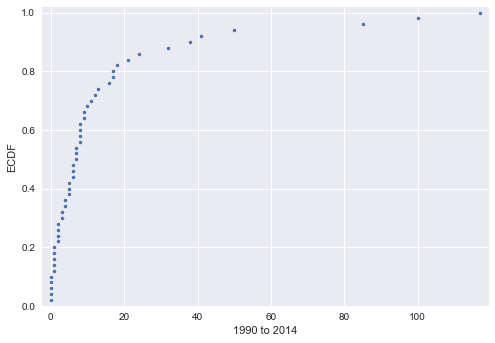

In [15]:
#Empirical Cumulative Distribution Function (ECDF)
import numpy as np
x=sorted(df_pulitzer.winnfinalists_1990_2014)
y=np.arange(1,len(x)+1)/len(x)
_=plt.plot(x,y,marker='.',linestyle='none')
_=plt.xlabel('1990 to 2014')
_=plt.ylabel('ECDF')
plt.margins(0.02)
plt.show()

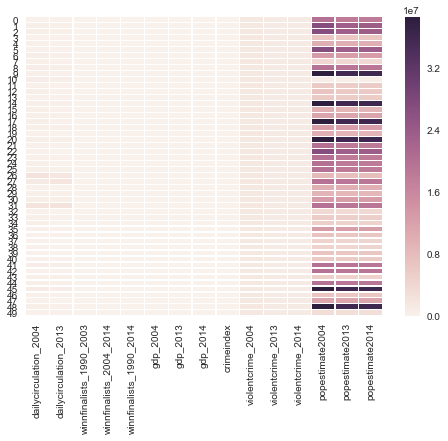

In [16]:
_=sns.set()
_=sns.heatmap(df_pulitzer.iloc[:,2:], linewidths=.25)
plt.show()

Observation: It appears that our data is sparse. 

### Observation:

We can see that Pulitzer prize is following 80-20 rule i.e. 80% of the newspaper population is under 10 pulitzer prize and 20% of the newspaper population is above 10 Pulitzer prize.

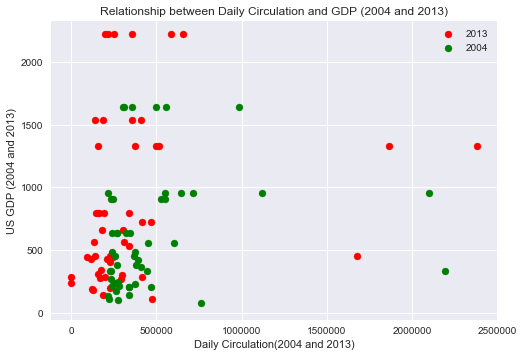

In [17]:
_=plt.scatter(df_pulitzer.dailycirculation_2013, df_pulitzer.gdp_2013,label='2013',color='r')
_=plt.scatter(df_pulitzer.dailycirculation_2004, df_pulitzer.gdp_2004,label='2004',color='g')
_=plt.xlabel("Daily Circulation(2004 and 2013)")
_=plt.ylabel("US GDP (2004 and 2013)")
_=plt.title("Relationship between Daily Circulation and GDP (2004 and 2013)")
_=plt.legend(loc='upper right')
plt.show()

As aniticipated, we see a positive relationship between GDP and Daily circulation.

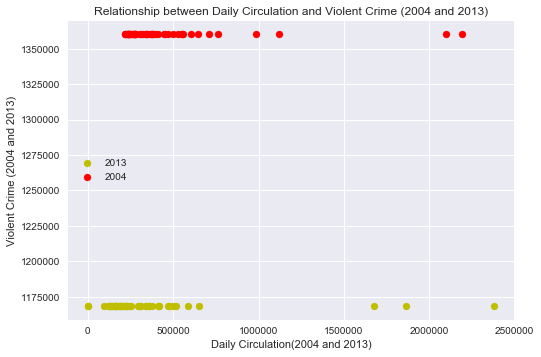

In [18]:
_=plt.scatter(df_pulitzer.dailycirculation_2013, df_pulitzer.violentcrime_2013,label='2013',color='y')
_=plt.scatter(df_pulitzer.dailycirculation_2004, df_pulitzer.violentcrime_2004,label='2004',color='r')
_=plt.xlabel("Daily Circulation(2004 and 2013)")
_=plt.ylabel("Violent Crime (2004 and 2013)")
_=plt.title("Relationship between Daily Circulation and Violent Crime (2004 and 2013)")
_=plt.legend(loc='center left')
plt.show()

We see non-linear negative relationship betweeen Daily Circulation and Violent Crime.

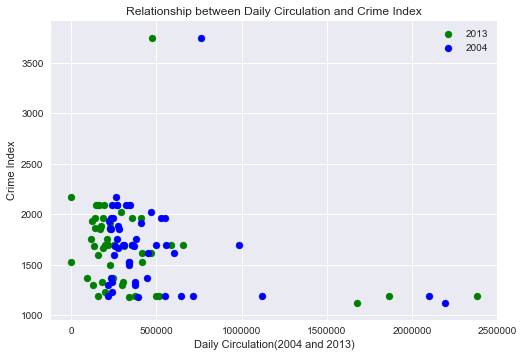

In [19]:
_=plt.scatter(df_pulitzer.dailycirculation_2013, df_pulitzer.crimeindex,label='2013',color='g')
_=plt.scatter(df_pulitzer.dailycirculation_2004, df_pulitzer.crimeindex,label='2004',color='b')
_=plt.xlabel("Daily Circulation(2004 and 2013)")
_=plt.ylabel("Crime Index")
_=plt.title("Relationship between Daily Circulation and Crime Index")
_=plt.legend(loc='upper right')
plt.show()

We see a linear positive relationship between Daily Circulation and Crime Index.

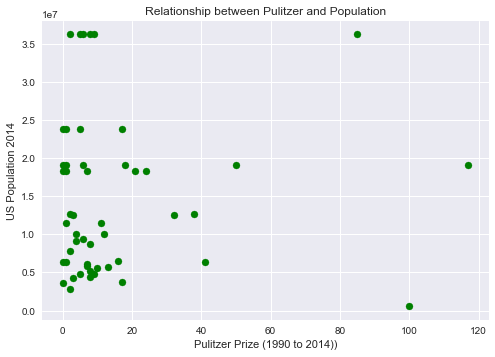

In [20]:
_=plt.scatter(df_pulitzer.winnfinalists_1990_2014, df_pulitzer.popestimate2014,color='g')
_=plt.xlabel("Pulitzer Prize (1990 to 2014))")
_=plt.ylabel("US Population 2014")
_=plt.title("Relationship between Pulitzer and Population")
plt.show()

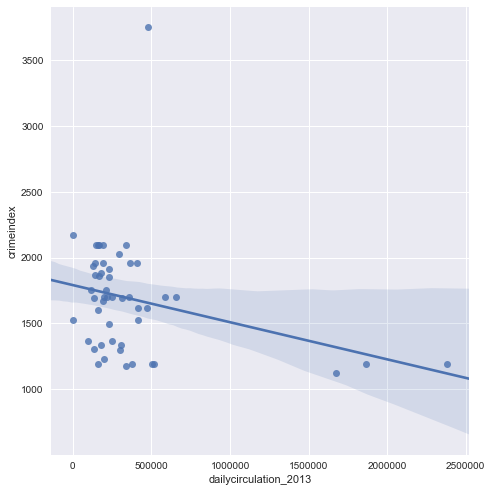

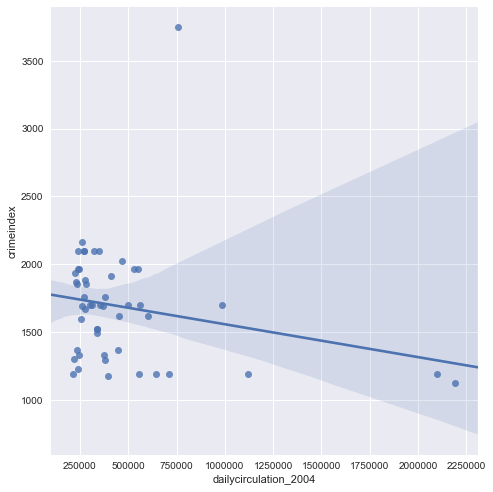

In [21]:
_=sns.lmplot(x="dailycirculation_2013", y="crimeindex", data=df_pulitzer, size=7)
_=sns.lmplot(x="dailycirculation_2004", y="crimeindex", data=df_pulitzer, size=7)
plt.show()

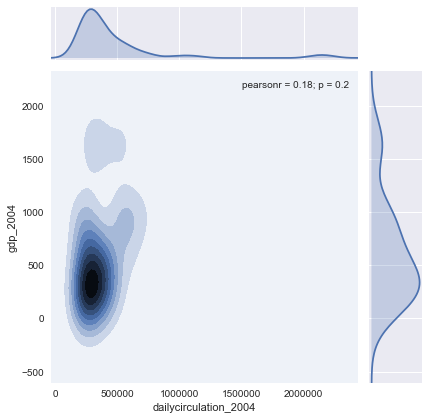

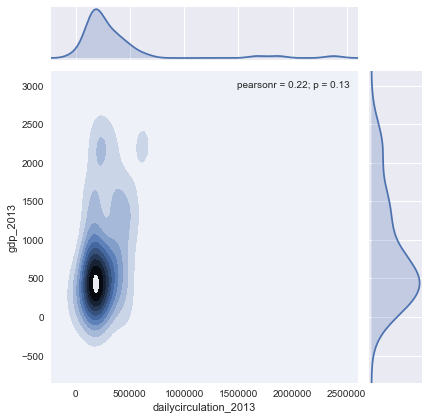

In [22]:
sns.jointplot(x='dailycirculation_2004',y='gdp_2004',data=df_pulitzer,kind='kde')
sns.jointplot(x='dailycirculation_2013',y='gdp_2013',data=df_pulitzer,kind='kde')
plt.show()

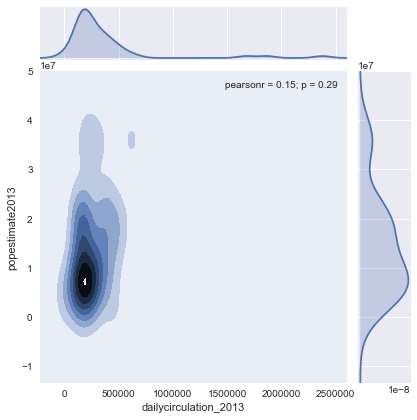

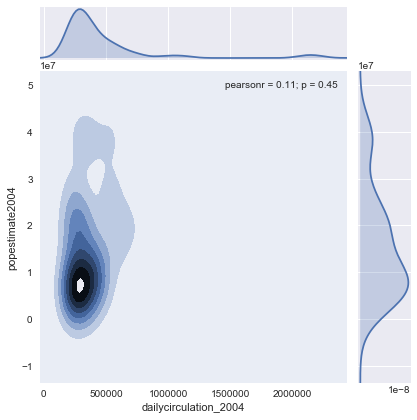

In [23]:
sns.jointplot(x='dailycirculation_2013',y='popestimate2013',data=df_pulitzer,kind='kde')
sns.jointplot(x='dailycirculation_2004',y='popestimate2004',data=df_pulitzer,kind='kde')
plt.show()

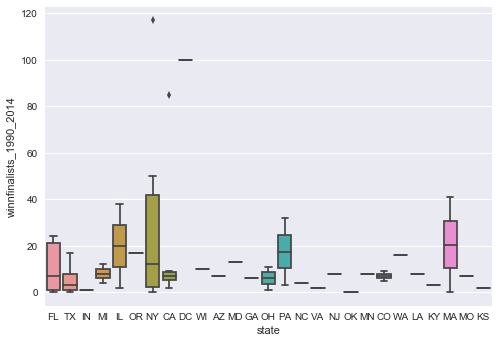

In [24]:
_=sns.boxplot(x='state',y='winnfinalists_1990_2014', \
            data=df_pulitzer)
plt.show()

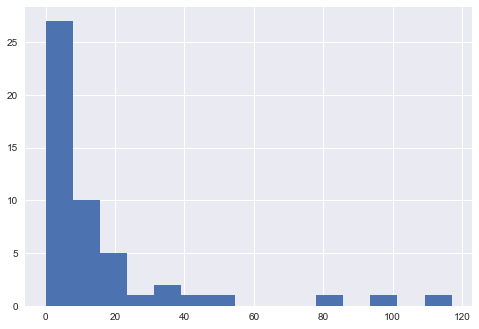

In [25]:
_=plt.hist(df_pulitzer['winnfinalists_1990_2014'],bins=15)
plt.show()

In [26]:
#sns.violinplot(x='state',y='winnfinalists_2004_2014',data=df_pulitzer[df_pulitzer.winnfinalists_2004_2014<=15])
#sns.boxplot(x='state',y='winnfinalists_2004_2014', \
#            data=df_pulitzer[(df_pulitzer.winnfinalists_2004_2014<=15) & (df_pulitzer.state!=['CA','NY','DC'])])
#_=sns.swarmplot(x='state',y='winnfinalists_1990_2014',data=df_pulitzer[(df_pulitzer.winnfinalists_1990_2014>0) \
#                                                                       & (df_pulitzer.winnfinalists_1990_2014<60)])

# Normalcy Test of Pulitzer Data

In [54]:
import scipy.stats as stats
from scipy.stats import kurtosis,skew
df_pulitzer.winnfinalists_1990_2014.describe()

count     50.000000
mean      15.060000
std       24.640609
min        0.000000
25%        2.000000
50%        7.000000
75%       15.250000
max      117.000000
Name: winnfinalists_1990_2014, dtype: float64

In [55]:
print("mean  : ", np.mean(df_pulitzer.winnfinalists_1990_2014))
print("var   : ", np.var(df_pulitzer.winnfinalists_1990_2014))
print("skew  : ",skew(df_pulitzer.winnfinalists_1990_2014))
print("kurt  : ",kurtosis(df_pulitzer.winnfinalists_1990_2014))
print('Median: ',np.median(df_pulitzer.winnfinalists_1990_2014))

if(stats.normaltest(df_pulitzer.winnfinalists_1990_2014)[1] < 0.05):
    print("Pulitzer Data is not a normal distribution.",'pValue:', \
          stats.normaltest(df_pulitzer.winnfinalists_1990_2014)[1])

mean  :  15.06
var   :  595.0164
skew  :  2.8072431554058634
kurt  :  7.563560952747379
Median:  7.0
Pulitzer Data is not a normal distribution. pValue: 1.5546437888e-11


It appears that Pulitzer data is not normally distributed. It could be possible that outliers are causing this skewness. We can see it visually in the below graph.

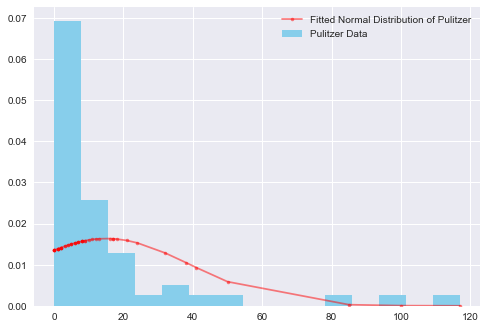

In [29]:
import numpy as np
from scipy.stats import kurtosis,skew
import scipy.stats as stats

_sorted=sorted(df_pulitzer.winnfinalists_1990_2014)
hmean = np.mean(_sorted)
hstd = np.std(_sorted)
pdf = stats.norm.pdf(_sorted, hmean, hstd) # this is fitted 
plt.plot(_sorted, pdf,marker='.',color='red', alpha=0.5,label='Fitted Normal Distribution of Pulitzer') 
# including temp_sorted here is crucial

_=plt.hist(df_pulitzer.winnfinalists_1990_2014, normed=True, bins=15,color = "skyblue", \
           ec="skyblue",lw=0,label='Pulitzer Data') 
#adding the data graph
_=plt.legend(loc='upper right')
plt.show()

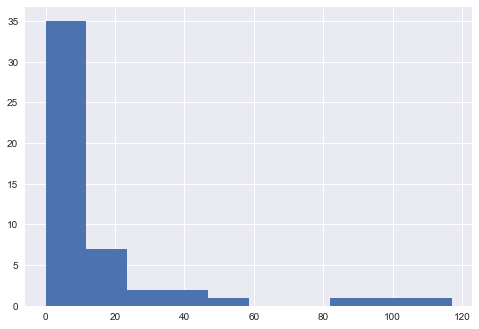

In [30]:
df_pulitzer.winnfinalists_1990_2014.hist() 
plt.show()
# we can see that we lot of newspapers with 0 and at the same time few with more than 60 prizes.

In [31]:
# removing outliers
df_altered=df_pulitzer[(df_pulitzer.winnfinalists_1990_2014>0) & \
                       (df_pulitzer.winnfinalists_1990_2014<30)].winnfinalists_1990_2014    

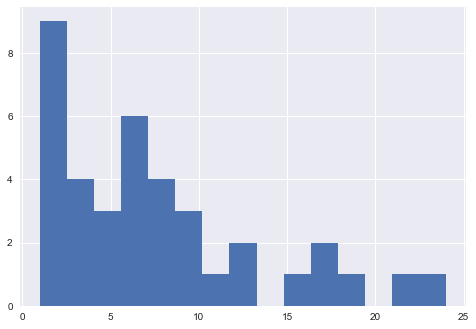

In [32]:
#checking the distribution
df_altered.hist(bins=15)
plt.show()

In [33]:
#performing normalcy test on the altered dataset
pval=stats.normaltest(df_altered)[1]
if(pval < 0.05):
    print("Pulitzer Data is not a normal distribution")

Pulitzer Data is not a normal distribution


### Observation:

It looks like that our Pulitzer Prize data is not normally distributed. This makes sense as it is a highly respected prize.

In [34]:
df_pulitzer.sample(3)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
2,Houston Chronicle,TX,549300.0,360251.0,2.0,3.0,5.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
44,Newsday,NY,553117.0,377744.0,12.0,6.0,18.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
26,USA Today,VA,2192098.0,1674306.0,1.0,1.0,2.0,331.0,449.0,459.0,1125.0,1360088.0,1168298.0,1165383.0,8317372.0,7673725.0,7751000.0


# K-Means Clustering

We plan to use the K-Means Clustering to maximize the distance between centroids and minimize the distance between data points and the respective centroid for the cluster they are in.

In [35]:
# preparing the feature set 
X= df_pulitzer.drop(['newspaper','state'], axis = 1) 

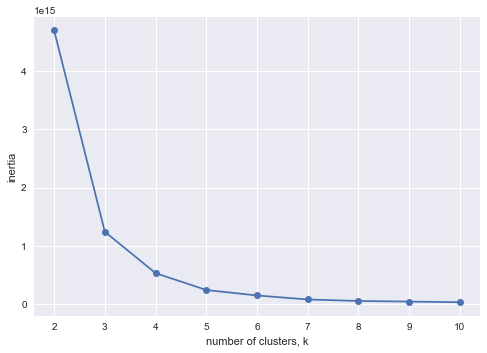

In [36]:
from sklearn.cluster import KMeans
Ks=range(2,11)
inertias = []

for k in Ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(Ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(Ks)
plt.show()

Observation:

we can see that between K=4 and K=5 the error did not drop sigficantly. We can safly select K=4 as our best case value of k

In [37]:
#using our best k
import numpy as np

model = KMeans(n_clusters=4)
model.fit(X)

df_pulitzer['cluster']=model.predict(X)

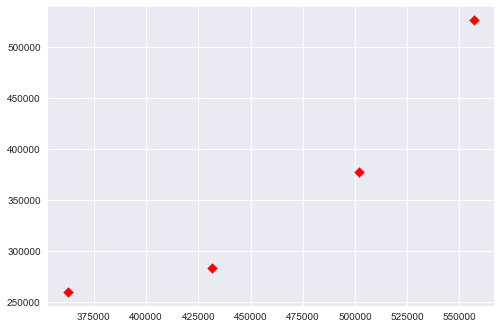

In [38]:
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
_=plt.scatter(centroids_x,centroids_y,marker='D', s=50,color='r')
plt.show()

In [39]:
centroids_x, centroids_y


(array([ 557029.46666667,  431373.16666667,  501870.33333333,
         362700.54545455]),
 array([ 526434.33333333,  283646.55555556,  377416.33333333,  259681.        ]))

In [40]:
nCluster, nPoint = np.unique(model.labels_, return_counts = True)
model.labels_,nCluster, nPoint

(array([0, 0, 0, 1, 3, 0, 3, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 2, 3, 3, 2, 0, 0,
        0, 0, 0, 1, 0, 3, 3, 3, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        1, 3, 2, 1], dtype=int32),
 array([0, 1, 2, 3], dtype=int32),
 array([15, 18,  6, 11]))

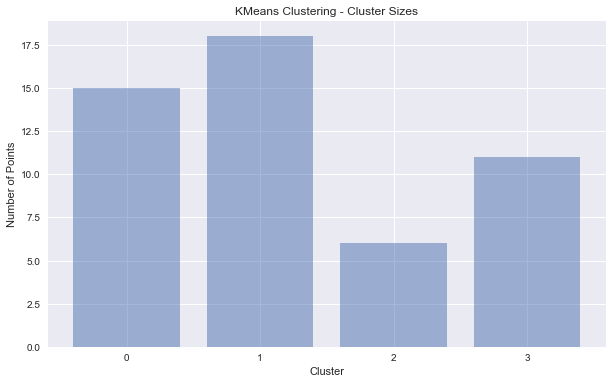

In [41]:
_=plt.figure(figsize = (10,6))
_=plt.bar(nCluster, nPoint, align = 'center', alpha = 0.5)
_=plt.xticks(nCluster)
_=plt.xlabel('Cluster')
_=plt.ylabel('Number of Points')
_=plt.title('KMeans Clustering - Cluster Sizes')
plt.show()

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
pca.fit(X)
pca_features=pca.transform(X)

df_pulitzer['x']=pca_features[:,0]
df_pulitzer['y']=pca_features[:,1]

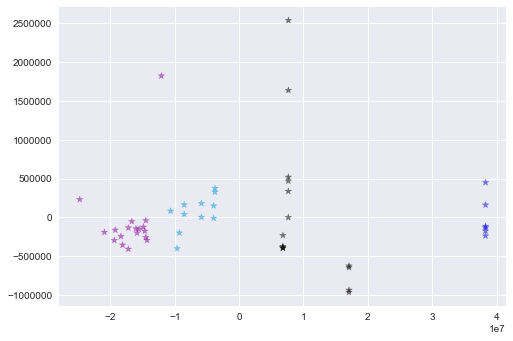

In [43]:
import matplotlib.cm as cm
c=[cm.spectral(float(i) /10) for i in df_pulitzer.cluster]
_=plt.scatter(df_pulitzer.x, df_pulitzer.y, alpha=0.5, marker='*',c=c)
plt.show()

In [44]:
df_result=df_pulitzer.groupby(['cluster', 'newspaper'])['state'].count().unstack('cluster')
df_result = df_result.fillna(0).reset_index()
df_result

cluster,newspaper,0,1,2,3
0,Arizona Republic,0.0,1.0,0.0,0.0
1,Atlanta Journal Constitution,0.0,0.0,0.0,1.0
2,Baltimore Sun,0.0,1.0,0.0,0.0
3,Boston Globe,0.0,1.0,0.0,0.0
4,Boston Herald,0.0,1.0,0.0,0.0
5,Charlotte Observer,0.0,0.0,0.0,1.0
6,Chicago Sun-Times,0.0,0.0,0.0,1.0
7,Chicago Tribune,0.0,0.0,0.0,1.0
8,Cleveland Plain Dealer,0.0,0.0,0.0,1.0
9,Columbus Dispatch,0.0,0.0,0.0,1.0


# Ploting the Clusters using Networkx

In [47]:
df_result.columns=['newspaper', 'C0', 'C1', 'C2', 'C3']

In [49]:
#selecting cluster data
df_C0=df_result[['newspaper','C0']][df_result['C0'] ==1] 
df_C1=df_result[['newspaper','C1']][df_result['C1'] ==1]
df_C2=df_result[['newspaper','C2']][df_result['C2'] ==1]
df_C3=df_result[['newspaper','C3']][df_result['C3'] ==1]

In [50]:
df_C0.C0= df_C0.C0.apply(lambda x: 'C0') # adding unique identifier for cluster
df_C1.C1= df_C1.C1.apply(lambda x: 'C1') # adding unique identifier for cluster
df_C2.C2= df_C2.C2.apply(lambda x: 'C2') # adding unique identifier for cluster
df_C3.C3= df_C3.C3.apply(lambda x: 'C3') # adding unique identifier for cluster

In [51]:
col=['newspaper', 'C']
df_C0.columns=col
df_C1.columns=col
df_C2.columns=col
df_C3.columns=col
frames = [df_C0, df_C1, df_C2,df_C3]
result = pd.concat(frames)
result

,newspaper,C
11,Dallas Morning News,C0
15,Fort Woth Star-Telegram,C0
16,Houston Chronicle,C0
18,Investor's Buisiness Daily,C0
22,Miami Herald,C0
26,New York Daily News,C0
27,New York Post,C0
28,New York Times,C0
30,Newsday,C0
33,Orlando Sentinel,C0


In [52]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

#Creating the Graph object
G=nx.from_pandas_dataframe(result, 'newspaper', 'C')

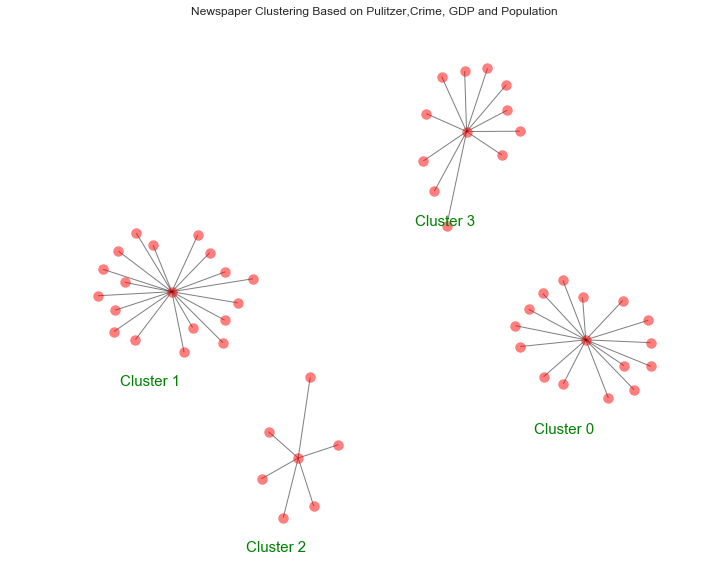

In [53]:
fig=plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

pos = nx.spring_layout(G,k=.25)
x0,y0=pos.get('C0')
x1,y1=pos.get('C1')
x2,y2=pos.get('C2')
x3,y3=pos.get('C3')

x0 +=-0.186
y0 +=-0.341

x1 +=-0.186
y1 +=-0.341

x2 +=-0.186
y2 +=-0.341

x3 +=-0.186
y3 +=-0.341

ax.text(x0,y0, 'Cluster 0',color='green', fontsize=15)
ax.text(x1,y1, 'Cluster 1',color='green', fontsize=15)
ax.text(x2,y2, 'Cluster 2',color='green', fontsize=15)
ax.text(x3,y3, 'Cluster 3',color='green', fontsize=15)


nx.draw_networkx(G, pos=pos, node_size=100, with_labels=False, alpha=0.5)
plt.axis('off')
plt.title('Newspaper Clustering Based on Pulitzer,Crime, GDP and Population')
plt.show()

# Conclusion:
We have mapped the newspapers into 4 clusters based on Crime, GDP, Population and Pulitzer.